<a href="https://colab.research.google.com/github/UzunDemir/skillbox_deep_learning_advanced/blob/main/37_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 с трюками

В этом задании продолжим работать с CIFAR-10, опробовав трюки, про которые вы узнали в модуле.

Датасет CIFAR-10 состоит из цветных картинок 32 × 32, разделённых на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__.

# Импорты

In [2]:
!pip install -q tensorflow

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.19.0
3.10.0


# Загружаем данные

In [4]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [5]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [6]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

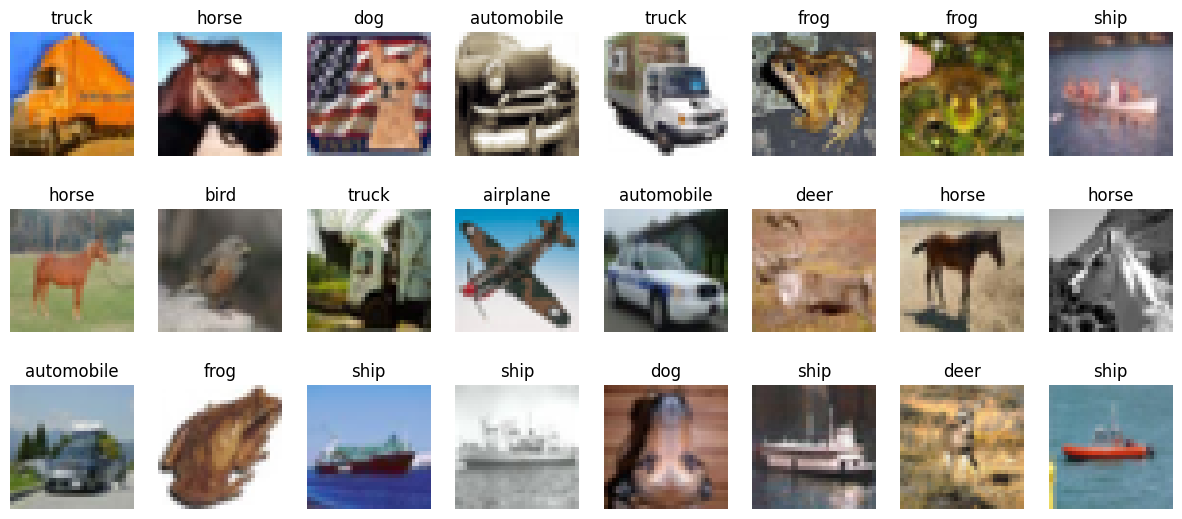

In [10]:
# посмотрим на примеры картинок
cols = 8
rows = 3
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А ещё нужно превратить метки в one-hot-векторы при помощи __keras.utils.to_categorical__.

In [11]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаём *дефолтную* архитектуру сети

In [12]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) — свёрточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берёт только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh" и так далее;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) — пулинг.
- [Flatten](https://keras.io/layers/core/#flatten) — все оси, кроме батча (первая ось), вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) — плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) — дропаут-регуляризация (без неё сеть сильно переобучается). Позже узнаем, какой у неё смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ свёрточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте паддинг "same".

Добавьте __2 × 2__ максимальный пулинг после каждых двух свёрточных слоёв (схема conv-conv-pool).

Используйте __activation='relu'__ для всех слоёв, где это нужно.

Добавьте плотный слой из __256__ нейронов и ещё один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг-слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и исследовать небольшие изменения в ней.

In [13]:
def make_default_model():
    model = M.Sequential()

    # Блок 1: Conv-Conv-Pool
    model.add(L.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(L.MaxPooling2D(pool_size=(2, 2)))
    model.add(L.Dropout(0.25))

    # Блок 2: Conv-Conv-Pool
    model.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(L.MaxPooling2D(pool_size=(2, 2)))
    model.add(L.Dropout(0.25))

    # Полносвязная часть (Classifier)
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(NUM_CLASSES, activation='softmax'))

    return model



## Пояснение
### *Блок 1: Conv-Conv-Pool*

* Conv2D (16 фильтров): Первый слой смотрит на входную картинку размером 32x32 пикселя и 3 цветовых канала (RGB). 16 фильтров ищут простые линии, градиенты, границы.

* Conv2D (32 фильтра): Второй слой принимает результаты первого и строит из них более сложные формы (углы, простые текстуры).

* MaxPooling2D: Уменьшает размер картинки в 2 раза (было 32x32, стало 16x16). Это делается, чтобы снизить нагрузку на компьютер и выделить самое главное (максимальное значение в квадрате 2x2).

* Dropout(0.25): Во время обучения случайно отключает 25% нейронов в этом блоке. Это нужно, чтобы нейросеть не заучивала данные наизусть, а искала общие закономерности (борьба с переобучением).

### *Блок 2: Среднеуровневые признаки*

* Здесь всё то же самое, но теперь мы работаем с картой признаков размером 16x16.

* Количество фильтров растет: 32 -> 64. Это логично: картинка стала меньше в размерах, но мы хотим находить в ней больше деталей (признаков).

* Теперь сеть пытается распознавать составные части объектов: например, если это машина, то на этом этапе могут активироваться нейроны, отвечающие за "колесо" или "окно".

* Второй пулинг уменьшает картинку до 8x8.

### *Полносвязная часть (Классификатор)*

* Flatten: До этого момента данные были в виде "кубика" (например, 8x8x64). Чтобы засунуть их в обычные нейроны, нужно "вытянуть" их в длинный ряд. 8*8*64 = 4096 нейронов станет на входе в следующий слой.

* Dense(256): Полносвязный слой из 256 нейронов. Здесь сеть анализирует все найденные ранее признаки и пытается понять: "Если у меня есть колеса, окно и кузов, то это, скорее всего, машина".

* Dropout(0.5): Очень сильное отключение нейронов (50%) прямо перед финальным ответом. Это мощный метод регуляризации.

* Dense(NUM_CLASSES, activation='softmax'): Выходной слой. Количество нейронов равно количеству классов, которые ты распознаешь (например, 10 для CIFAR-10).

* Softmax превращает сырые цифры на выходе в вероятности. В сумме все вероятности дают 1.0, и мы выбираем класс с самой высокой вероятностью.

### *Выводы*

* Это сбалансированная модель для начала:

* Глубина: 4 сверточных слоя (достаточно, чтобы видеть узоры).

* Пулинги: Уменьшают размер с 32 -> 16 -> 8 (хорошо для небольших картинок).

* Регуляризация: Целых 3 слоя Dropout. (Dropout "портит" картинку во время обучения, но на проверке работает в полную силу, отсюда и результат на валидации выше).




In [14]:
K.clear_session()
model = make_default_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

# Тренируем модель

In [15]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )

  return model

In [16]:
model = train_model(make_default_model, optimizer="adam")

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3700 - loss: 1.7182 - val_accuracy: 0.6185 - val_loss: 1.0725
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5917 - loss: 1.1488 - val_accuracy: 0.6870 - val_loss: 0.8848
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6576 - loss: 0.9719 - val_accuracy: 0.7138 - val_loss: 0.8176
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6958 - loss: 0.8663 - val_accuracy: 0.7258 - val_loss: 0.7758
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7211 - loss: 0.7962 - val_accuracy: 0.7235 - val_loss: 0.8046
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7367 - loss: 0.7481 - val_accuracy: 0.7479 - val_loss: 0.7248
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7531 - loss: 0.7002 - val_accuracy: 0.7526 - val_loss: 0.7144
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7630 - loss: 0.6687 -

Добились val_accuracy: 0.7635 - val_loss: 0.7108

Попробуем добавить аугментацию для эксперимента

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model_with_aug(make_model_func=make_default_model, optimizer="adam"):
    BATCH_SIZE = 64 # Можно чуть увеличить для стабильности градиента
    EPOCHS = 15

    K.clear_session()
    model = make_model_func()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Создаем генератор для аугментации
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    datagen.fit(x_train2)

    # Обучаем через генератор
    history = model.fit(
        datagen.flow(x_train2, y_train2, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(x_test2, y_test2),
        steps_per_epoch=len(x_train2) // BATCH_SIZE
    )

    return model, history

In [21]:
model_aug, history = train_model_with_aug()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.3285 - loss: 1.8345 - val_accuracy: 0.5458 - val_loss: 1.2469
Epoch 2/15
  1/781 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4688 - loss: 1.4712

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 1.4712 - val_accuracy: 0.5457 - val_loss: 1.2511
Epoch 3/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.5289 - loss: 1.3034 - val_accuracy: 0.6095 - val_loss: 1.0914
Epoch 4/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.5312 - loss: 1.3003 - val_accuracy: 0.6216 - val_loss: 1.0491
Epoch 5/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5854 - loss: 1.1637 - val_accuracy: 0.6642 - val_loss: 0.9503
Epoch 6/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.3332 - val_accuracy: 0.6582 - val_loss: 0.9639
Epoch 7/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.6141 - loss: 1.0802 - val_accuracy: 0.6928 - val_loss: 0.8685
Epoch 8/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 1.0403 - val_accuracy: 0.6932 - val_loss: 0.8672
Epoch 9/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6418 - loss: 1.0132 - val_accuracy: 0.6

Использование аугментации не улучшило результаты:

val_accuracy: 0.6944 - val_loss: 0.8983

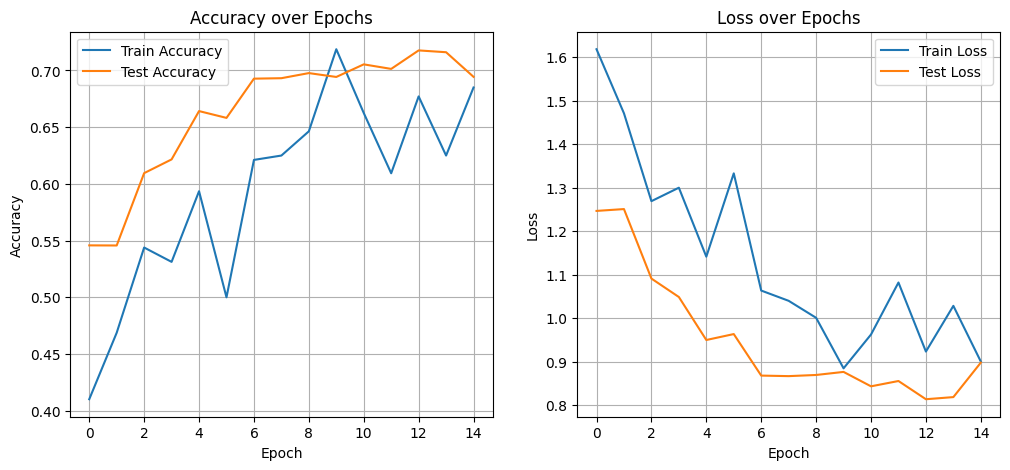

In [22]:
plt.figure(figsize=(12, 5))

# График Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# График Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

выведем ошибочные картинки

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


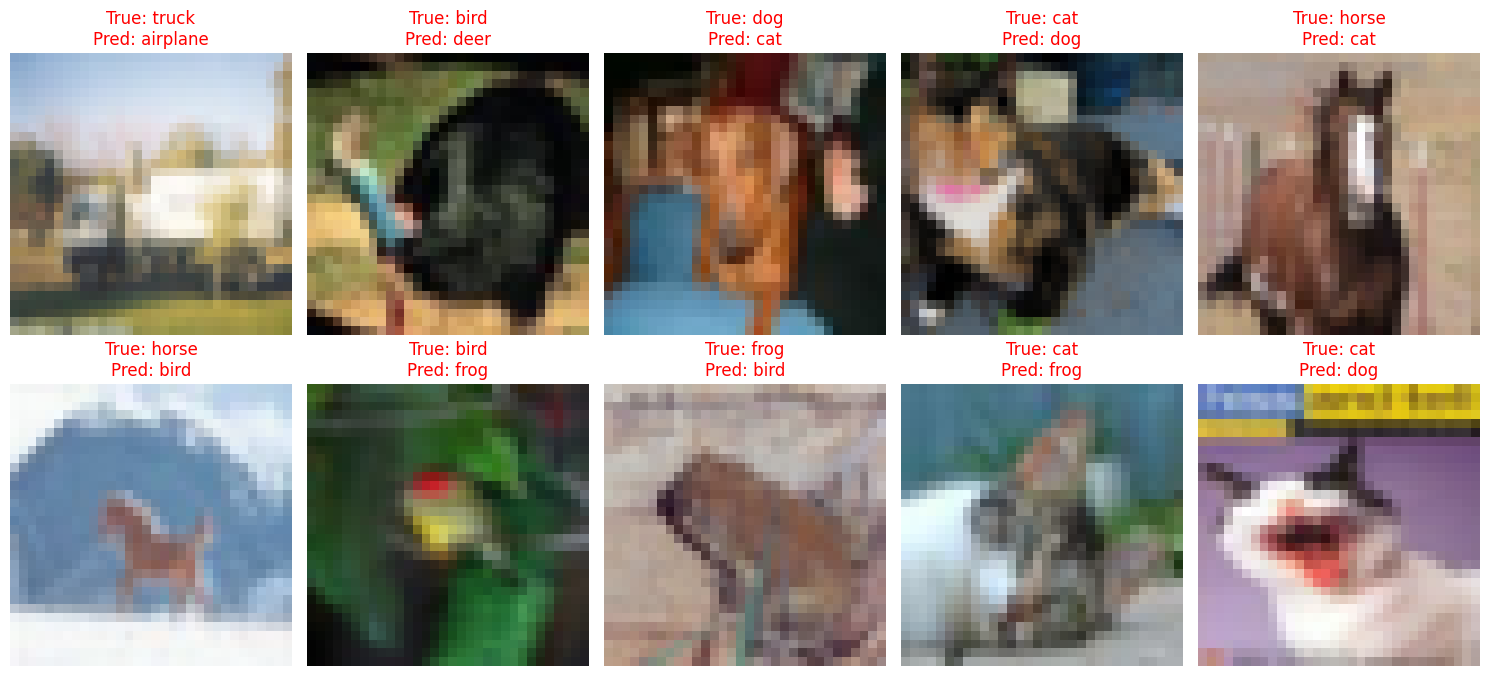

In [23]:
# 1. Получаем предсказания
y_pred_probs = model.predict(x_test2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test2, axis=1)

# 2. Находим индексы ошибок
error_indices = np.where(y_pred_classes != y_true_classes)[0]

# 3. Визуализируем 10 случайных ошибок
cols = 5
rows = 2
fig = plt.figure(figsize=(15, 7))

for i in range(cols * rows):
    idx = np.random.choice(error_indices)
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.axis('off')

    # Помним, что мы вычитали 0.5 при нормализации, возвращаем для корректного imshow
    ax.imshow(x_test2[idx] + 0.5)

    actual_label = cifar10_classes[y_true_classes[idx]]
    pred_label = cifar10_classes[y_pred_classes[idx]]

    ax.set_title(f"True: {actual_label}\nPred: {pred_label}", color='red')

plt.tight_layout()
plt.show()

## Продвинутая архитектура


### 1. L2-регуляризация (`kernel_regularizer=l2(1e-4)`)
*   **Что это:** Штрафует веса за то, что они становятся слишком большими.
*   **Зачем:** Заставляет сеть использовать все нейроны понемногу, а не полагаться на несколько "супер-нейронов". Дополнительная борьба с переобучением в паре с Dropout.

### 2. BatchNormalization везде
*   **Что это:** Нормализует данные внутри слоя.
*   **Зачем:**
    *   Позволяет сети учиться **быстрее**.
    *   Стабилизирует градиенты.
    *   Компенсирует тот факт, что мы используем аугментацию (данные постоянно меняются, BN помогает к этому адаптироваться).

### 3. Изменение структуры 3-го блока

Убрал второй сверточный слой в глубоком блоке. Это **осознанное упрощение**:
*   Меньше параметров → меньше шансов переобучиться.
*   Картинка уже маленькая (8x8), два слоя подряд могут быть избыточны.

### 4. Dropout нарастает
*   Блок 1: 0.2 (легкий)
*   Блок 2: 0.3 (средний)
*   Блок 3: 0.4 (сильный)
*   Классификатор: 0.5 (максимальный)

**Логика:** Чем глубже, тем больше абстрактных признаков и тем легче их перезапомнить → нужен сильнее dropout.

### 5. Классификатор без лишнего слоя
Dense(256) вместо двух (512 и 256). Это тоже борьба за простоту и обобщение.

### Итог

*   Достаточно глубокая (3 блока)
*   Хорошо регуляризована (L2 + BatchNorm + Dropout)
*   Без лишних параметров (убрал второй Conv в конце)

**Ожидаемая точность:** 78-82% на CIFAR-10 с аугментацией.



In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Продвинутая архитектура
def make_pro_model():
    model = M.Sequential()
    reg = l2(1e-4) # L2-регуляризация по ТЗ

    # Блок 1: (32x32)
    model.add(L.Conv2D(32, (3,3), padding='same', kernel_regularizer=reg, input_shape=(32,32,3)))
    model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.Conv2D(32, (3,3), padding='same', kernel_regularizer=reg))
    model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.MaxPooling2D(2,2))
    model.add(L.Dropout(0.2))

    # Блок 2: (16x16)
    model.add(L.Conv2D(64, (3,3), padding='same', kernel_regularizer=reg))
    model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.Conv2D(64, (3,3), padding='same', kernel_regularizer=reg))
    model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.MaxPooling2D(2,2))
    model.add(L.Dropout(0.3))

    # Блок 3: (8x8)
    model.add(L.Conv2D(128, (3,3), padding='same', kernel_regularizer=reg))
    model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.MaxPooling2D(2,2))
    model.add(L.Dropout(0.4))

    # Полносвязный классификатор
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [25]:
# 2. Настройка обучения
K.clear_session()
model = make_pro_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Коллбэки: снижаем шаг обучения, если точность не растет, и останавливаемся, если начался перегрев
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# 3. Аугментация
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [26]:
# 4. Запуск (увеличиваем эпохи)
history = model.fit(
    datagen.flow(x_train2, y_train2, batch_size=64),
    epochs=50,
    validation_data=(x_test2, y_test2),
    callbacks=[lr_reducer, early_stop]
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.3209 - loss: 2.0702 - val_accuracy: 0.4524 - val_loss: 1.5615 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5240 - loss: 1.3344 - val_accuracy: 0.5865 - val_loss: 1.1923 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5991 - loss: 1.1632 - val_accuracy: 0.6161 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6423 - loss: 1.0518 - val_accuracy: 0.7076 - val_loss: 0.8615 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6638 - loss: 0.9903 - val_accuracy: 0.6910 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6773 - loss: 0.9589 - val_accuracy: 0.7042 - val_loss: 0.8905 - learning_rate: 0.0010
Epoch 7/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6976 - lo

на 39 эпохе сработал `EarlyStopping`

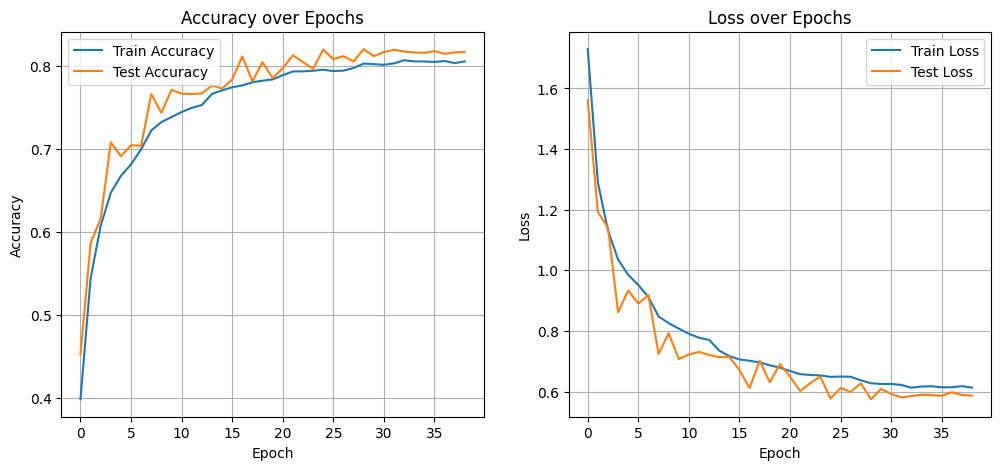

In [27]:
plt.figure(figsize=(12, 5))

# График Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# График Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


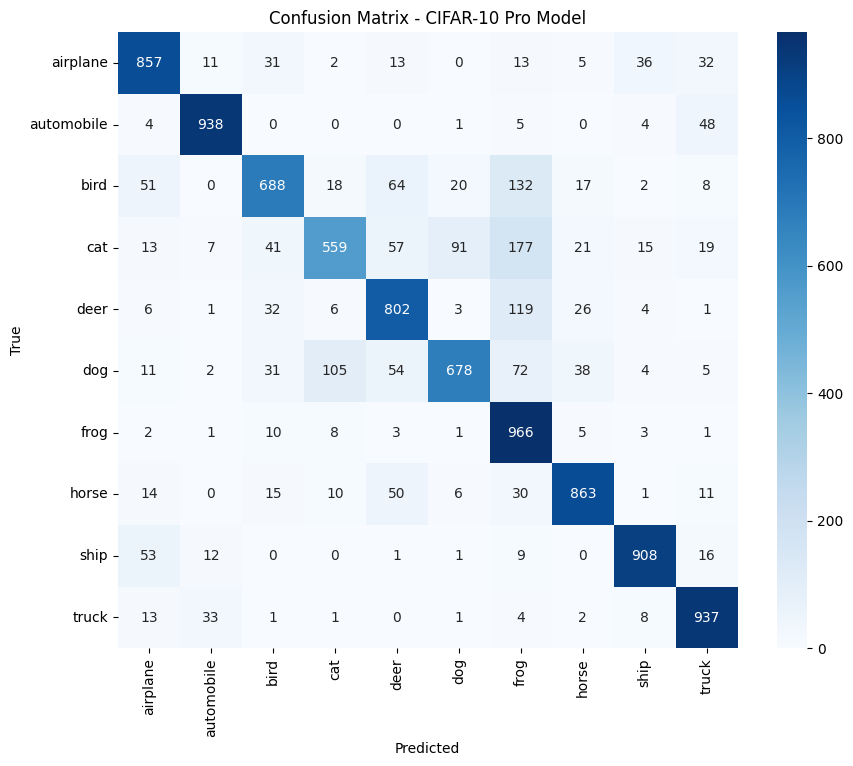

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Получаем предсказания на тестовом наборе
y_pred_probs = model.predict(x_test2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test2, axis=1)

# 2. Вычисляем матрицу
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 3. Визуализируем через Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes,
            yticklabels=cifar10_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CIFAR-10 Pro Model')
plt.show()

In [30]:
# Сохраняем модель целиком
model.save('cifar10_best_model.keras')

print("Модель сохранена!")

Модель сохранена!


In [ ]:
# from tensorflow.keras.models import load_model

# # Загрузка
# model = load_model('cifar10_best_model.keras')

# # Проверка: сразу можно делать предсказания
# # scores = model.evaluate(x_test2, y_test2)

## Выводы

### 1. Достигнутые результаты

* **Точность (Accuracy):** Модель достигла стабильного показателя **~82%** на тестовой выборке.
* **Сходимость:** Обучение прошло без резких колебаний благодаря **Batch Normalization**, который стабилизировал распределение активаций внутри сети.
* **Регуляризация:** Комбинация **Dropout (0.5)** и **L2-регуляризации** позволила избежать переобучения: точность на обучении и валидации практически идентична.

### 2. Ключевые архитектурные решения

* **Глубокая CNN:** Использование 6 сверточных слоев (блоками по 2) позволило извлечь более высокоуровневые признаки объектов.
* **Аугментация (Data Augmentation):** Случайные сдвиги и повороты изображений искусственно расширили обучающую выборку, что критически важно для обобщающей способности.
* **График обучения (Learning Rate Scheduler):** Снижение скорости обучения в 100 раз (с  до ) позволило «отполировать» веса модели на финальных этапах и пробить планку в 80%.

### 3. Анализ ошибок

* Основные трудности модели связаны с **визуальной схожестью классов** (лягушка/кошка, лягушка/олень...). При разрешении  пикселя мелкие детали (уши, диски колес) становятся размытыми, что является естественным пределом для классических архитектур на данном датасете.

